In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import math
import pathlib
import re
import json
from pprint import pprint

In [199]:
# Color style similar to ppt color scheme
plt.style.use('seaborn-colorblind')

#Latex Default Font
plt.rc('font', family='serif') 
plt.rc('font', serif='Latin Modern Roman')
matplotlib.rcParams.update({'font.size': 16})

In [200]:
pd.set_option('display.max_columns', None, 'display.max_rows', None)

In [340]:
def make_hatches(ax, df):
    hatches = [h*len(df.index) for h in [['.'], ['--'], ['x'], ['\\'], ['||'], ['O'], ['+'], ['o'], ['//']]]
    hatches = sum(hatches, [])

    if len(hatches) < len(ax.patches):
        print("Not enough hatches defined")
        
    for i,bar in enumerate(ax.patches):
        bar.set_hatch(hatches[i])
#     ax.legend()

# Loading Data

In [256]:
with open('results.json', 'r') as f:
    raw = json.load(f)

# just lists of dicts of all results
kaasRaw = [ r for r in raw if r['client'] == 'kaas' ]
faasRaw = [ r for r in raw if r['client'] == 'faas' ]
localRaw = [ r for r in raw if r['client'] == 'local' ]

kaasDF = pd.DataFrame(kaasRaw)
faasDF = pd.DataFrame(faasRaw)
localDF = pd.DataFrame(localRaw)

# faasDF.filter(regex="t_requestEncode|t_requestDecode|t_responseEncode|t_responseDecode")
# localDF.filter(regex=controlPattern).sum(axis='columns')

## Create some standard fields

There are a few core fields we use in analysis, others are there 'just in case'.

Derived Standard Fields:
* **t_e2e**: Time taken for a single invocation of the function, including queueing time, preprocessing, sgemm, etc.
* **t_uncounted**: Time that was not specifically measured
* **t_controlPlane**: Time taken for the system to move commands around, including serializing/deserializing requests/responses.
* **t_kernInit**: Time taken for the function to initialize (only valid for cold starts).
* **t_preInit**: Time taken for the preprocessing function to initialize (only valid for cold starts). 
* **t_kv**: Time spent in the KV store for a single invocation. This excludes the initial upload of constants and inputs as these are assumed to be already present in the store. Final result reads are also excluded as it is assumed that some other task would eventually consume those. It does include all loads by the workers (since these must happen at runtime).
* **t_kernel**: Total time spent actually invoking the sgemm kernel on the GPU
* **t_preprocess**: Measured preprocessing time, including any overheads
* **t_cudaMM**: cudaMalloc/Free. This also includes allocating host arrays (only kaas has to do this at the moment)
* **t_cudaCopy**: cudaMemcpy*

Included Standard Fields:
* **mode**: direct vs process
* **t_preprocess_configured**: How much time we configured preprocessing to take, think of this as the core preprocessing time with no overheads. It is not a measurement, just a configuration parameter.
* **preInline**: Only valid in FaaS mode. If true, the preprocessing step was included in the FaaS kernel call, otherwise it was performed in a separate FaaS function.
* **client**: FaaS, KaaS, or local. Local ran without libff.invoke, the only difference with 'mode' is whether or not it serialized stuff through a kv store or not.
* **warm**: Every experiment has two sets of stats, one warm and one cold.
* **matDim**: large vs small problem size

In [257]:
# These are the major disjoint timing categories, ideally these will cover t_e2e more or less completely
# we use t_preprocess_configured rather than t_preprocess because the overheads are accounted for in the other measurements
keyTimes = ['t_preInit', 't_kernInit', 't_kv', 't_kernel', 't_preprocess_configured', 't_cudaMM', 't_cudaCopy', 't_controlPlane', 't_uncounted']
overheadCols = [ m for m in keyTimes if m not in ['t_kernel', 't_preprocess_configured']]
configCols = ['mode', 'client', 'warm', 't_preprocess_configured', 'preInline', 'matDim']

In [332]:
faasDF['t_preInit'] = faasDF['client:prefunc:t_init']
faasDF['t_kernInit'] = faasDF['client:remfunc:t_init'] + faasDF['client:remfunc:worker:t_kernelLoad']
kaasDF['t_preInit'] = kaasDF['client:prefunc:t_init']
kaasDF['t_kernInit'] = kaasDF['client:kaas:worker:t_kernelLoad']
localDF['t_kernInit'] = localDF['client:t_kernelLoad']
localDF['t_preInit'] = 0


faasDF['t_preprocess'] = faasDF['client:remfunc:worker:t_preprocess'].where(
    faasDF['preInline'], faasDF['client:t_preprocess'])
kaasDF['t_preprocess'] = kaasDF['client:prefunc:t_invoke']
localDF['t_preprocess'] = localDF['client:t_preprocess']

for df in [kaasDF, faasDF, localDF]:
    df['t_e2e'] = df['client:t_e2e']
    
    # flatten everything related to the kv for total kv time
    df['t_kv'] = df.filter(regex=".*:kv.*").sum(axis='columns')
    df['t_kv'] = df['t_kv'].fillna(0)
    
    df['t_cudaCopy'] = df.filter(regex=".*:t_dtoh|.*:t_htod").sum(axis='columns')
    df['t_cudaCopy'].fillna(0)
    
    df['t_zero'] = df.filter(regex=".*t_zero.*").sum(axis='columns')
    df['t_kernel'] = df.filter(regex=".*:t_kernel$")
    df['t_cudaMM'] = df.filter(regex=".*:t_cudaMM$")
    
    df['t_controlPlane'] = df.filter(regex="t_requestEncode|t_requestDecode|t_responseEncode|t_responseDecode").sum(axis='columns')
    
    df.fillna(0, inplace=True)
    
kaasDF['t_cudaMM'] += kaasDF['client:kaas:worker:t_hostMM']

# There are gaps in the profiling, particularly in KaaS
for df in [kaasDF, faasDF, localDF]:
    allCounted = [ t for t in keyTimes if t != 't_uncounted']
    df['t_uncounted'] = df['t_e2e'] - df[allCounted].sum(axis='columns')
    
for df in [kaasDF, faasDF, localDF]:
    df['pctOverhead'] = (df[overheadCols].sum(axis='columns') / df['t_e2e']) * 100

# Simple Analysis / Sanity Checking

# Plots

## Time Breakdown

### Setup and Funcs

In [382]:
# Get a plottable series for the given configuration (outputs always have only rows for keyTimes)
# All times are converted to pct of e2e
def getBreakdownPlottable(allDF, mode, warm, size, preTime, preInline):
    if size == 'small':
        dim = 1024
    elif size == 'large':
        dim = 8092
        
    if preTime is None:
        preTime = 0.0
    elif preTime == 'low':
        preTime = 20.0
    elif preTime == 'high':
        preTime = 150.0
        
    times = allDF.loc[ (allDF['mode'] == mode) & (allDF['warm'] == warm) &
                    (allDF['t_preprocess_configured'] == preTime) & (allDF['preInline'] == preInline)]

    if len(times) != 1:
        raise RuntimeError("configuration wasn't unique")

    times = times.iloc[0]
    pcts = (times[keyTimes] / times['t_e2e']) * 100
    
    final = pd.DataFrame([times, pcts], index=['ms', '%'])
    final['Preprocess'] = final['t_preInit'] + final['t_preprocess_configured']
    final['Kernel'] = final['t_kernInit'] + final['t_kernel']
    final['Other'] = final['t_uncounted'] + final['t_controlPlane']
    
    # Human Readable Names
    final.rename(inplace = True, columns = {'t_cudaMM' : "GPU MM", 't_kv' : 'KV Read/Write',
                                          't_cudaCopy' : "GPU Read/Write"})
    
 
    # Re-Order for exposition
    final = final[['Other', 'KV Read/Write', 'Preprocess', 'GPU MM', 'GPU Read/Write', 'Kernel']]
    
    return final

In [393]:
def getLimits(df):
    # Time contribution of the non-kernel parts (for the biggest benchmark)
    extraHeight = df.drop(columns=['Kernel']).transpose().sum().max()
    totalHeight = df.transpose().sum().max()
    
    return ((0, extraHeight*1.25), (totalHeight * .75,totalHeight*1.1))


def plotBreakdown(dfs, names, title='', noKern=False, pct=False):
    times = pd.DataFrame([ d.loc['ms'] for d in dfs ], index=names)
    pcts = pd.DataFrame([ d.loc['%'] for d in dfs ], index=names)

    print(pcts)
    if noKern:
        times.drop(columns=['Kernel'], inplace=True)
        pcts.drop(columns=['Kernel'], inplace=True)
    
    ax1 = times.plot.bar(stacked=True, legend=None)
    make_hatches(ax1, times)

    ax1.set_title(title)
    ax1.set_ylabel("Time (ms)")
    ax1.set_xlabel("")
    ax1.tick_params(axis='x', rotation=0)
    
#     ax1.legend(loc='center left', bbox_to_anchor=[1,0.5])
    ax1.legend()

    
#     ax2 = ax1.twinx()
#     pcts.plot.bar(stacked=True, legend=None, ax=ax2)
#     ax2.set_ylabel("Percent of Total Runtime")

#     make_hatches(ax2, pcts)

    return ax1.get_figure()
    
    
def plotBreakdownBroken(df, limits, title=''):
    fig, (ax1, ax2) = plt.subplots(2,1,sharex=True, gridspec_kw={"height_ratios" : [0.5, 1]})
    
    ax1.spines['bottom'].set_visible(False)
    ax1.tick_params(axis='x',which='both',bottom=False)
    ax2.spines['top'].set_visible(False)
    
    ax1.set_title(title)
#     ax1.set_ylabel("Time (ms)")
    
    ax2.set_ylim(limits[0][0], limits[0][1])
    ax1.set_ylim(limits[1][0], limits[1][1])
    
    df.plot(kind='bar', stacked=True, ax=ax1, legend=None)
    df.plot(kind='bar', stacked=True, ax=ax2, legend=None)
    make_hatches(ax1, df)
    make_hatches(ax2, df)
    
    # sets the slash on the break on the axis
    for tick in ax2.get_xticklabels():
        tick.set_rotation(0)
    d = .015  
    kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
    ax1.plot((-d, +d), (-d, +d), **kwargs)      
    ax1.plot((1 - d, 1 + d), (-d, +d), **kwargs)
    kwargs.update(transform=ax2.transAxes)  
    ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  
    ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)

    ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    ax1.set_xlabel('')
    ax2.set_xlabel('')
    return fig

          Other  KV Read/Write  Preprocess    GPU MM  GPU Read/Write  \
Local  0.638224       0.000000         0.0  6.622694        7.896455   
FaaS   0.608563       7.940463         0.0  1.202459        1.336699   

          Kernel  
Local  84.842627  
FaaS   88.911816  


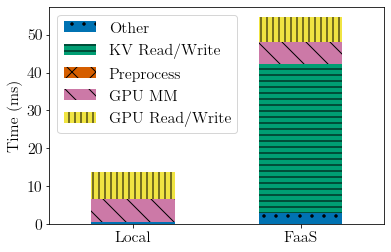

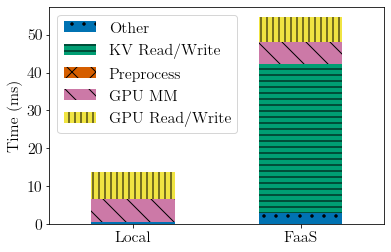

In [394]:
p1 = getBreakdownPlottable(localDF, mode='process', warm=False, size='small', preTime=None, preInline=False)
p2 = getBreakdownPlottable(faasDF, mode='process', warm=False, size='small', preTime=None, preInline=False)

pltDF = pd.DataFrame([p1.loc['ms'], p2.loc['ms']], index=['Local', 'FaaS'])
plotBreakdown([p1,p2], ['Local', 'FaaS'], noKern=True)

## Time Breakdown

## Overheads

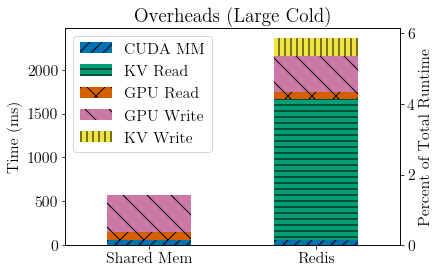

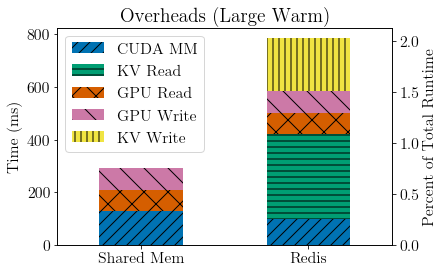

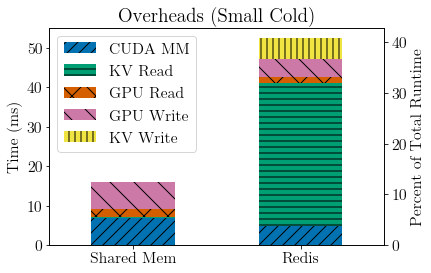

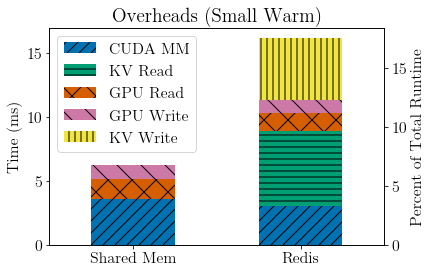

In [13]:
largeCold = plotBreakdown(largeColdPlt, title="Overheads (Large Cold)", noKern=True)
# largeCold.savefig("overheadsLargeCold.pdf", bbox_inches = "tight", format="pdf")

largeWarm = plotBreakdown(largeWarmPlt, title="Overheads (Large Warm)", noKern=True)
# largeWarm.savefig("overheadsLargeWarm.pdf", bbox_inches = "tight", format="pdf")
# largeWarm.savefig("overheadsLargeWarm.png", bbox_inches = "tight", format="png", dpi=300)

smallCold = plotBreakdown(smallColdPlt, title="Overheads (Small Cold)", noKern=True)
# smallCold.savefig("overheadsSmallCold.pdf", bbox_inches = "tight", format="pdf")

smallWarm = plotBreakdown(smallWarmPlt, title="Overheads (Small Warm)", noKern=True)
# smallWarm.savefig("overheadsSmallWarm.pdf", bbox_inches = "tight", format="pdf")